In [119]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.special import gamma,loggamma
from tqdm import tqdm
import emcee
import corner

from astropy import units as u 
from astropy.table import Table
from math import *

from snewpy.neutrino import ThreeFlavor, MassHierarchy, MixingParameters, ThreeFlavorMixingParameters,FourFlavorMixingParameters
from snewpy.models.ccsn import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.models.ccsn import Zha_2021
from snewpy.models.ccsn import Tamborra_2014
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
#from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

In [120]:
sukh_param_sfho=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='SFHo')
sukh_param_ls220=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')


forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 26.99)

zha_param=list(params for params in Zha_2021.get_param_combinations() if params['progenitor_mass'].value == 26)

tamb_param=list(params for params in Tamborra_2014.get_param_combinations() if params['progenitor_mass'].value == 27
               and params['direction']==1)

In [121]:
sukh_model_sfho = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[0]
              }

sukh_model_ls220 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[0]
              }

forn_model = {'name': 'Fornax_2022',
            'param': forn_param[0]
              }

zha_model = {'name': 'Zha_2021',
            'param': zha_param[0]
              }

tamb_model = {'name': 'Tamborra_2014',
            'param': tamb_param[0]
              }

In [122]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
model_orignals=[Sukhbold_2015,Sukhbold_2015,Fornax_2022,Zha_2021,Tamborra_2014]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        if mod['name']=='Fornax_2022':
            with open("ThreeFlavor_{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))
        else:
            with open("Three_Flavor_{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))

In [123]:
def compute_hits(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
    data=hits[id5:id6]
    return data

In [124]:
def compute_hits_scaled(scale,dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]
    
    data_scaled=data*scale
    return data_scaled

In [125]:
def compute_hits_without_sub_bg(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    bg1 = sim.detector.i3_bg(dt,size=hits.size) + sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
    
    return sig[id5:id6]

In [126]:
def compute_model_energy_with_plot(model,hierarchy,t_vals,e_vals):
    spectra=[]
    for i,t in enumerate(t_vals*u.ms):
        ispec=model.get_transformed_spectra(t,e_vals*u.MeV,
                                            AdiabaticMSW(ThreeFlavorMixingParameters(**MixingParameters(mass_order=hierarchy))))
        spectra.append(ispec[ThreeFlavor(1)])
        
    T, E = np.meshgrid(t_vals,e_vals)
    T_flat = T.flatten()
    E_flat = E.flatten()
    spectra=np.array(spectra)
    
    max_fluxes = np.max(spectra, axis=1) 
    normalized_fluxes = spectra / max_fluxes[:, np.newaxis]
    normalized_fluxes_flat=normalized_fluxes.T.flatten()
    
    delta_E = np.diff(e_vals)
    delta_E = np.append(delta_E, delta_E[-1])  
    
    mean_energies=[]
    for i in range(spectra.shape[0]):
        numerator = np.sum(e_vals * spectra[i] * delta_E)
        denominator = np.sum(spectra[i] * delta_E)
        mean_energies.append(numerator / denominator)
        
    return T_flat, E_flat, normalized_fluxes_flat, mean_energies

In [127]:
def compute_model_energy(model,hierarchy,t_vals,e_vals):
    spectra=[]
    for i,t in enumerate(t_vals*u.ms):
        ispec=model.get_transformed_spectra(t,e_vals*u.MeV,
                                            AdiabaticMSW(ThreeFlavorMixingParameters(**MixingParameters(mass_order=hierarchy))))
        spectra.append(ispec[ThreeFlavor(1)])
    
    spectra=np.array(spectra)
    
    delta_E = np.diff(e_vals)
    delta_E = np.append(delta_E, delta_E[-1])  
    
    mean_energies=[]
    for i in range(spectra.shape[0]):
        numerator = np.sum(e_vals * spectra[i] * delta_E)
        denominator = np.sum(spectra[i] * delta_E)
        mean_energies.append(numerator / denominator)
        
    return mean_energies

In [128]:
def compute_model_alpha(model,hierarchy,t_vals,e_vals):
    spectra=[]
    for i,t in enumerate(t_vals*u.ms):
        ispec=model.get_transformed_spectra(t,e_vals*u.MeV,
                                            AdiabaticMSW(ThreeFlavorMixingParameters(**MixingParameters(mass_order=hierarchy))))
        spectra.append(ispec[ThreeFlavor(1)])
    
    spectra=np.array(spectra)

    mean_E2s=[]
    for i in range(spectra.shape[0]):
        integrand = (e_vals**2) * spectra[i]
        integral_E2_flux = np.trapz(integrand, e_vals)
        integral_flux = np.trapz(spectra[i], e_vals)
        average_E2 = integral_E2_flux / integral_flux
        mean_E2s.append(average_E2)
        
    mean_Es=compute_model_energy(model,hierarchy,t_vals,e_vals)
    
    mean_E2s=np.array(mean_E2s)
    mean_Es=np.array(mean_Es)
    
    pinches=(2*mean_Es**2-mean_E2s)/(mean_E2s-mean_Es**2)
    return pinches

In [129]:
def compute_data_energy(model,hierarchy,t_vals,e_vals,cov):
    mean_E=compute_model_energy(model,hierarchy,t_vals,e_vals)
    reco_E=[]
    for i,t in enumerate(t_vals):
        reco_E.append(np.random.normal(loc=mean_E[i],scale=sigma,size=None))
    return reco_E

In [130]:
def compute_data_energy_alpha(model,hierarchy,t_vals,e_vals,cov):
    mean_E=compute_model_energy(model,hierarchy,t_vals,e_vals)
    mean_alpha=compute_model_alpha(model,hierarchy,t_vals,e_vals)
    reco_E=[]
    reco_alpha=[]
    for i,t in enumerate(t_vals):
        E,alpha=multivariate_normal=np.random.multivariate_normal([mean_E[i], mean_alpha[i]],cov)
        reco_E.append(E)
        reco_alpha.append(alpha)
    return reco_E,reco_alpha

In [131]:
def get_flux(t,energies,mean_E,a,model):
    L=np.interp(t, model.time, model.luminosity[ThreeFlavor.NU_E_BAR].to('erg/s')).value
    energies=energies*u.MeV
    energies=energies.to('erg').value
    Ea=mean_E*u.MeV
    Ea=Ea.to('erg').value
    fluxes=[]
    for E in energies:
        flux=np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
                        - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)
        fluxes.append(flux.value)
    return fluxes

C:\Users\sanya\AppData\Local\Temp\ipykernel_48900\1138826656.py:30: UserWarning: Argument `eos` is deprecated.
  sim_energies[name].append(compute_model_energy(model_originals[i](**params[i][0]),MassHierarchy.NORMAL,times,energies))
C:\Users\sanya\AppData\Local\Temp\ipykernel_48900\1138826656.py:31: UserWarning: Argument `eos` is deprecated.
  sim_energies[name].append(compute_model_energy(model_originals[i](**params[i][0]),MassHierarchy.INVERTED,times,energies))
C:\Users\sanya\AppData\Local\Temp\ipykernel_48900\1138826656.py:33: UserWarning: Argument `eos` is deprecated.
  sim_alphas[name].append(compute_model_alpha(model_originals[i](**params[i][0]),MassHierarchy.NORMAL,times,energies))
C:\Users\sanya\AppData\Local\Temp\ipykernel_48900\1138826656.py:34: UserWarning: Argument `eos` is deprecated.
  sim_alphas[name].append(compute_model_alpha(model_originals[i](**params[i][0]),MassHierarchy.INVERTED,times,energies))


Text(0.5, 1.0, 'Energy Reconstruction')

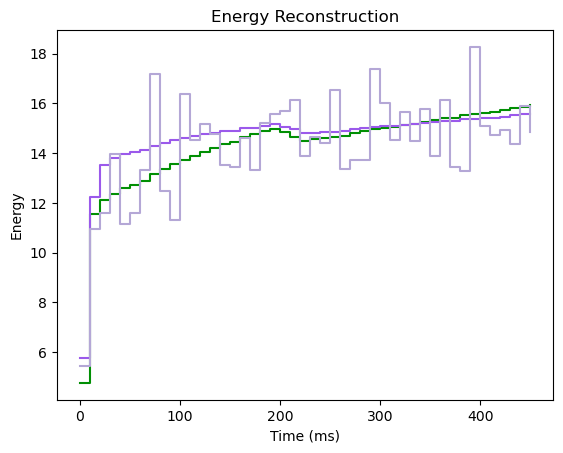

In [139]:
dt=10*u.ms
dist=10*u.kpc
times=np.arange(0,460,10)
energies=np.arange(0, 50, 1)

params=[sukh_param_sfho,sukh_param_ls220,forn_param,zha_param,tamb_param]
model_originals=[Sukhbold_2015,Sukhbold_2015,Fornax_2022,Zha_2021,Tamborra_2014]

covariance = [[6**2, .95*6*5], 
              [.95*6*5, 5**2]] 
data_energy,data_alpha=compute_data_energy_alpha(Sukhbold_2015(**sukh_param_sfho[0]),MassHierarchy.NORMAL,times,energies,cov)
#data_hits=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s,sims['forn'][1])

sim_energies = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }

sim_alphas = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,name in enumerate(mod_names):
    sim_energies[name].append(compute_model_energy(model_originals[i](**params[i][0]),MassHierarchy.NORMAL,times,energies))
    sim_energies[name].append(compute_model_energy(model_originals[i](**params[i][0]),MassHierarchy.INVERTED,times,energies))
    
    sim_alphas[name].append(compute_model_alpha(model_originals[i](**params[i][0]),MassHierarchy.NORMAL,times,energies))
    sim_alphas[name].append(compute_model_alpha(model_originals[i](**params[i][0]),MassHierarchy.INVERTED,times,energies))


plt.step(times, sim_energies['sukh_sfho'][0], where='post',color='#018f04',label='Model - NH Energy')
plt.step(times, sim_energies['sukh_sfho'][1], where='post',color='#9b59eb',label='Model - IH Energy')
plt.step(times, data_energy, where='post',color='#b4a7d6',label='Data - NH Energy')
plt.xlabel('Time (ms)')
plt.ylabel('Energy')
plt.title('Energy Reconstruction')
#plt.legend(loc='lower right')

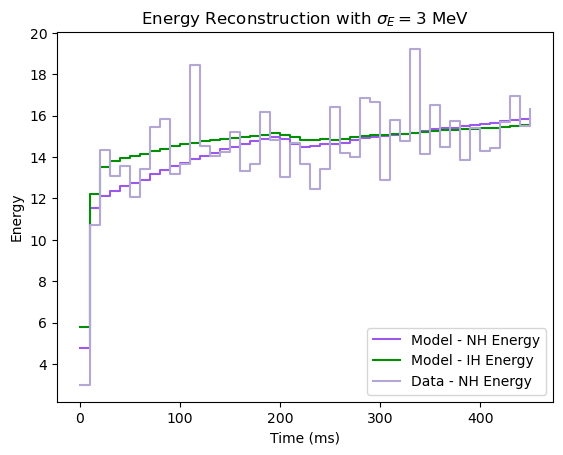

In [137]:
plt.step(times, sim_energies['sukh_sfho'][0], where='post',color='#9b59eb',label='Model - NH Energy')
plt.step(times, sim_energies['sukh_sfho'][1], where='post',color='#018f04',label='Model - IH Energy')
plt.step(times, data_energy, where='post',color='#b4a7d6',label='Data - NH Energy')
plt.xlabel('Time (ms)')
plt.ylabel('Energy')
plt.title(r'Energy Reconstruction with $\sigma_E = 3$ MeV')
plt.legend(loc='lower right')
plt.savefig('norm_sig_indep',dpi=300)

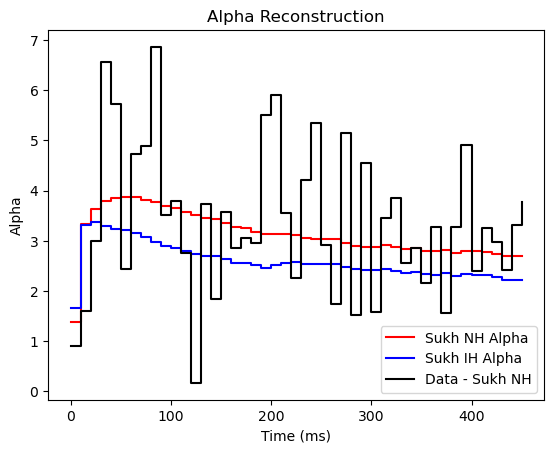

In [45]:
plt.step(times, sim_alphas['sukh_sfho'][0], where='post',color='red',label='Sukh NH Alpha')
plt.step(times, sim_alphas['sukh_sfho'][1], where='post',color='blue',label='Sukh IH Alpha')
plt.step(times, data_alpha, where='post',color='black',label='Data - Sukh NH')
plt.xlabel('Time (ms)')
plt.ylabel('Alpha')
plt.title('Alpha Reconstruction')
plt.legend(loc='lower right')

(0.0, 25.0)

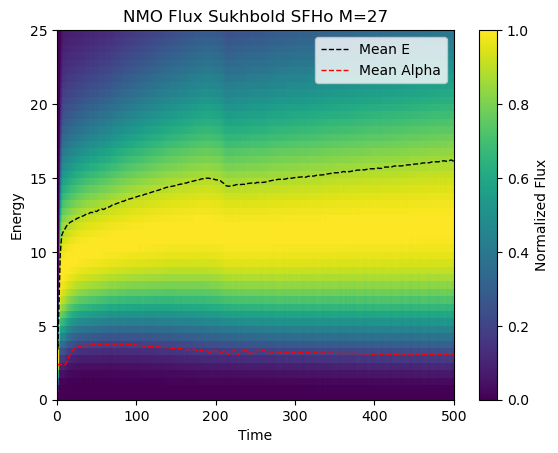

In [46]:
E_vals=np.linspace(0,50,100)
t_vals=np.linspace(0,500,500)

T_flat, E_flat, fluxes_flat, mean_energies = compute_model_energy_with_plot(Sukhbold_2015(**sukh_param_sfho[0]),
                                                                  MassHierarchy.NORMAL,t_vals,E_vals)

hist = plt.hist2d(T_flat, E_flat, weights=fluxes_flat, bins=[500, 100], cmap='viridis')

colorbar = plt.colorbar(hist[3])
colorbar.set_label('Normalized Flux')

sim_alpha=compute_model_alpha(model_originals[i](**params[i][0]),MassHierarchy.NORMAL,t_vals,E_vals)
plt.plot(t_vals,mean_energies,color='black',lw=1,ls='--',label='Mean E')
plt.plot(t_vals,sim_alpha,color='red',lw=1,ls='--',label='Mean Alpha')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('NMO Flux Sukhbold SFHo M=27')
plt.ylim(0,25)

C:\Users\sanya\AppData\Local\Temp\ipykernel_48900\4282259525.py:4: UserWarning: Argument `eos` is deprecated.
  model=Zha_2021(**zha_param[0])
C:\Users\sanya\AppData\Local\Temp\ipykernel_48900\2129754530.py:10: RuntimeWarning: divide by zero encountered in log
  - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)


Text(0.5, 1.0, 'parametric fluxes for t=0 ms')

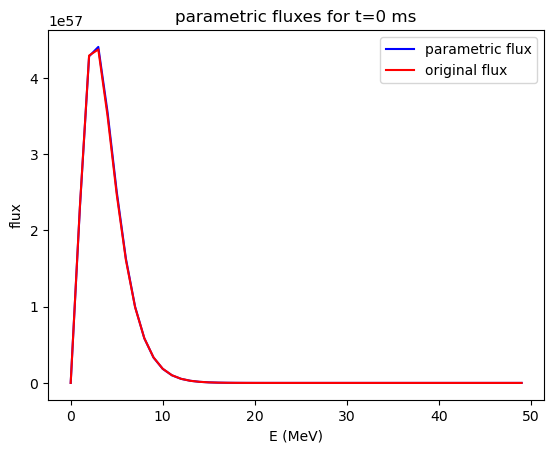

In [82]:
#take energy spectrum from a given time and plot it and plot the flux function on top
times=np.arange(0,460,10)
energies=np.arange(0, 50, 1)
model=Zha_2021(**zha_param[0])

fluxes_reco = get_flux(0*u.ms,energies,sim_energies['zha'][0][0],sim_alphas['zha'][0][0],model)
fluxes_original = model.get_transformed_spectra(0*u.ms,energies*u.MeV,
                                AdiabaticMSW(ThreeFlavorMixingParameters(**MixingParameters(mass_order=MassHierarchy.NORMAL))))[ThreeFlavor.NU_E_BAR]

plt.plot(energies,np.array(fluxes_reco)*5.5,color='blue',label='parametric flux')
plt.plot(energies,fluxes_original,color='red',label='original flux')

plt.ylabel('flux')
plt.xlabel('E (MeV)')
plt.legend()
plt.title('parametric fluxes for t=0 ms')

In [106]:
def log_prob_with_e_alpha(theta, model_hits, data_hits, model_e, data_e, model_a, data_a, cov, betamin, betamax, bmin, bmax):
    beta,bg=theta
    
    if bmin <= bg <= bmax and betamin <= beta <= betamax:
        log_prior = np.log(1/(betamax-betamin)*1/(bmax-bmin))
        return log_likelihood_poisson(bg,beta,model_hits,data_hits) + log_likelihood_energy_alpha(model_e,data_e,
                                                                                        model_a, data_a, cov)+ log_prior
    
    return -np.inf 

In [105]:
def log_likelihood_poisson(bg,scale,model_hits,data_hits):
    result=0
    for i in range(len(model_hits)):
        result+=data_hits[i]*np.log(bg+scale*model_hits[i])-bg-scale*model_hits[i]-lgamma(data_hits[i]+1)
    return result

In [104]:
def log_likelihood_energy_alpha(pred_e, dat_e, pred_a, dat_a, cov):
    sig_E = np.sqrt(cov[0][0])
    sig_a = np.sqrt(cov[1][1])
    rho = cov[0][1]/(sig_E*sig_a)
    
    result=0
    for i in range(len(pred_e)):
        result += np.log(1/(2*np.pi*sig_a*sig_E*np.sqrt(1-rho**2))) - .5/(1-rho**2)*(
        (dat_e[i]-pred_e[i])**2/(sig_E**2) - 2*rho*(dat_e[i]-pred_e[i])*(dat_a[i]-pred_a[i])/(sig_E*sig_a) 
        + (dat_a[i]-pred_a[i])**2/(sig_a**2) )
    return result

In [107]:
def compute_log_integral(data_hits,model_sim,data_e,model_e,data_a,model_a,cov,dist,dt):

    model_hits=compute_hits(dist,dt,-.5*u.s,.46*u.s,model_sim)
    
    betamin=0
    betamax=30000/np.max(model_hits)
    
    self=model_sim.detector
    bg_mean= self.i3_dom_bg_mu * dt.to(u.s).value * self.n_i3_doms + self.dc_dom_bg_mu * dt.to(u.s).value * self.n_dc_doms
    bg_var= (self.i3_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_i3_doms))**2 + (self.dc_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_dc_doms))**2
    bg_sig=np.sqrt(bg_var)
    
    bmin= bg_mean-3*bg_sig
    bmax= bg_mean+3*bg_sig
    
    ndim = 2
    nwalkers = 32
    
    bminguess= bg_mean-1*bg_sig
    bmaxguess= bg_mean+1*bg_sig

    initial_positions = np.random.uniform([betamin, bminguess], [betamax, bmaxguess], (nwalkers, ndim))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_with_e_alpha, args=(model_hits, data_hits, 
                                                                            model_e,data_e, model_a, data_a, cov,
                                                                            betamin, betamax, bmin, bmax))

    nsteps = 1000
    sampler.run_mcmc(initial_positions, nsteps)

    burn_in = 100
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    logprob=[log_prob_with_e_alpha((beta,b), model_hits, data_hits, 
                                                model_e,data_e, model_a, data_a, cov,
                                                betamin, betamax, bmin, bmax) for beta,b in samples]
    
    bs=samples[:,0]
    betas=samples[:,1]
    integration_area=(np.max(bs)-np.min(bs))*(np.max(betas)-np.min(betas))
    logint=np.log(integration_area/len(samples[:,0]))+logsumexp(logprob)

    return logint

In [108]:
def log_probs_with_energies(data_sim,model_sims, data_mod, model_energies, model_alphas, cov,priors,dist,dt,hierarchy,errs):
    log_probs_nh=[]
    log_probs_ih=[]
    times=np.arange(0,460,10)
    energies=np.arange(0, 50, 1)
    
    for j in tqdm(range(errs)):
        data_hits=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s,data_sim)
        data_e,data_a=compute_data_energy_alpha(data_mod,hierarchy,times,energies,cov)

        log_prob_nh=[]
        log_prob_ih=[]
        for k,name in enumerate(model_sims.keys()):
            if(priors[k]!=0):
                log_p_d_nh=compute_log_integral(data_hits,model_sims[name][0], 
                                                data_e, model_energies[name][0], data_a, model_alphas[name][0], 
                                                cov, dist,dt)
                log_p_d_ih=compute_log_integral(data_hits,model_sims[name][1], 
                                                data_e, model_energies[name][1], data_a, model_alphas[name][1], 
                                                cov, dist,dt)
                print(name, log_p_d_nh,log_p_d_ih)
                
                log_prob_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(priors[k]))
                log_prob_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(priors[k]))
                
        prob_nh=logsumexp(log_prob_nh)
        prob_ih=logsumexp(log_prob_ih)
        
        log_probs_nh.append(prob_nh)
        log_probs_ih.append(prob_ih)
            
    return log_probs_nh, log_probs_ih

In [112]:
def log_probs_with_energies_mult_priors(data_sim,model_sims, data_mod, model_energies, model_alphas, sigma,priors,dist,dt,hierarchy,errs):
    log_ratios=[]
    times=np.arange(0,460,10)
    energies=np.arange(0, 50, 1)
    
    for j in tqdm(range(errs)):
        data_hits=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s,data_sim)
        data_e,data_a=compute_data_energy_alpha(data_mod,hierarchy,times,energies,cov)
        
        log_prob_nh=[]
        log_prob_ih=[]
        log_ratio=[]
        for k,name in enumerate(model_sims.keys()):
            log_p_d_nh=compute_log_integral(data_hits,model_sims[name][0], 
                                                data_e, model_energies[name][0], data_a, model_alphas[name][0], 
                                                cov, dist,dt)
            log_p_d_ih=compute_log_integral(data_hits,model_sims[name][1], 
                                                data_e, model_energies[name][1], data_a, model_alphas[name][1], 
                                                cov, dist,dt)
            log_prob_nh.append(log_p_d_nh)
            log_prob_ih.append(log_p_d_ih)
 
        for i,prior in enumerate(priors):   
            p_nh=[]
            p_ih=[]
            for k,pro in enumerate(log_prob_nh):
                log_p_d_nh=pro
                log_p_d_ih=log_prob_ih[k]
                
                p_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))
                p_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))

            prob_nh=logsumexp(p_nh)
            prob_ih=logsumexp(p_ih)
            
            if(hierarchy==MassHierarchy.NORMAL):
                log_ratio.append(prob_nh-prob_ih)
            else:
                log_ratio.append(prob_ih-prob_nh)
        log_ratios.append(log_ratio)
            
    return log_ratios

In [140]:
prior_list=np.linspace(.2,.9,8)
covariance = [[6**2, .95*6*5], 
             [.95*6*5, 5**2]] 
ratios_ih={
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
        }
    
ratios_nh={
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
    }

for i,mod_name in enumerate(ratios_ih.keys()):
    all_priors=[]
    for j,prior in enumerate(prior_list):
        priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
        priors[i]=prior
        all_priors.append(priors)

    mod_ratios_ih=log_probs_with_energies_mult_priors(sims[mod_name][1],sims, model_originals[i](**params[i][0]),
                                                       sim_energies, sim_alphas, cov, all_priors,10*u.kpc,10*u.ms,
                                                       MassHierarchy.INVERTED,1)
        
    mod_ratios_nh=log_probs_with_energies_mult_priors(sims[mod_name][0],sims, model_originals[i](**params[i][0]),
                                                       sim_energies, sim_alphas, cov, all_priors,10*u.kpc,10*u.ms,
                                                       MassHierarchy.NORMAL,1)
    ratios_ih[mod_name].append(mod_ratios_ih)
    ratios_nh[mod_name].append(mod_ratios_nh)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:34<00:00, 394.86s/it]
C:\Users\sanya\AppData\Local\Temp\ipykernel_48900\4143122069.py:27: UserWarning: Argument `eos` is deprecated.
  mod_ratios_ih=log_probs_with_energies_mult_priors(sims[mod_name][1],sims, model_originals[i](**params[i][0]),
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:52<00:00, 292.93s/it]
C:\Users\sanya\AppData\Local\Temp\ipykernel_48900\4143122069.py:31: UserWarning: Argument `eos` is deprecated.
  mod_ratios_nh=log_probs_with_energies_mult_priors(sims[mod_name][0],sims, model_originals[i](**params[i][0]),
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:55<00:00, 295.42s/it]


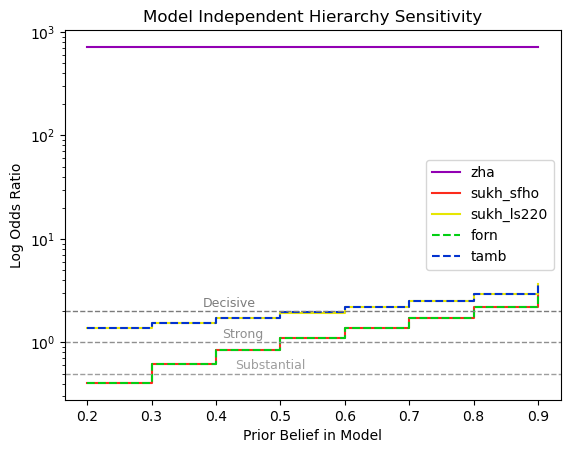

In [146]:
colors=['#9200b3','#fc2b1c','#e6e602','#02cf13','#0232cf']
labels=['zha','sukh_sfho', 'sukh_ls220', 'forn', 'tamb']
names=['zha','sukh_sfho', 'sukh_ls220', 'forn', 'tamb']
linestyles=['-','-','-','--','--']
for i,mod_name in enumerate(names):
    if(ratios_nh[mod_name][0][0][0]<ratios_ih[mod_name][0][0][0]):
        plt.step(prior_list,ratios_nh[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])
    else:
        plt.step(prior_list,ratios_ih[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])
plt.legend()
plt.title('Model Independent Hierarchy Sensitivity')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.2,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.1,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.55,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')
#plt.ylim(400,600)

In [145]:
np.savez('nh_ratios_e_alpha_10kpc',ratios_nh, allowPickle=True)
np.savez('ih_ratios_e_alpha_10kpc',ratios_ih, allowPickle=True)